**Import** **Libraries**

In [46]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
import scipy
from PIL import Image
from scipy import ndimage
import h5py
from sklearn.metrics import mean_squared_error
from sklearn.metrics import confusion_matrix
import random
%matplotlib inline

In [47]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**Loadting H5 Dataset**

In [48]:
def load_dataset():
    train_dataset = h5py.File('/content/drive/MyDrive/ADS-2/train_catvnoncat.h5', "r")
    train_set_x_orig = np.array(train_dataset["train_set_x"][:]) # your train set features
    train_set_y_orig = np.array(train_dataset["train_set_y"][:]) # your train set labels

    test_dataset = h5py.File('/content/drive/MyDrive/ADS-2/test_catvnoncat.h5', "r")
    test_set_x_orig = np.array(test_dataset["test_set_x"][:]) # your test set features
    test_set_y_orig = np.array(test_dataset["test_set_y"][:]) # your test set labels

    classes = np.array(test_dataset["list_classes"][:]) # the list of classes
    
    train_set_y_orig = train_set_y_orig.reshape((1, train_set_y_orig.shape[0]))
    test_set_y_orig = test_set_y_orig.reshape((1, test_set_y_orig.shape[0]))
    
    return train_set_x_orig, train_set_y_orig, test_set_x_orig, test_set_y_orig, classes

In [49]:
train_set_x_orig, train_set_y, test_set_x_orig, test_set_y, classes = load_dataset()

In [50]:
print("The classes are labelled as for 0:- "+ classes[0].decode("utf-8") +" and for 1:- " + classes[1].decode("utf-8"))

The classes are labelled as for 0:- non-cat and for 1:- cat


y = [1], it's a 'cat' picture.


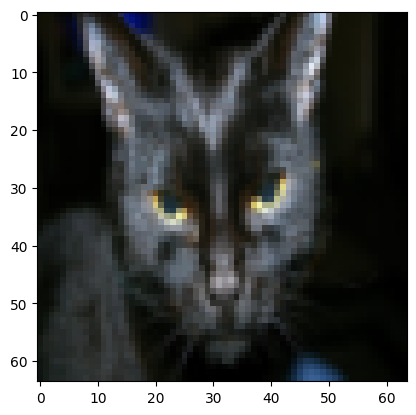

In [51]:
# Example of a picture
index = 25
plt.imshow(train_set_x_orig[index])
print ("y = " + str(train_set_y[:, index]) + ", it's a '" + classes[np.squeeze(train_set_y[:, index])].decode("utf-8") +  "' picture.")

y = [0], it's a 'non-cat' picture.


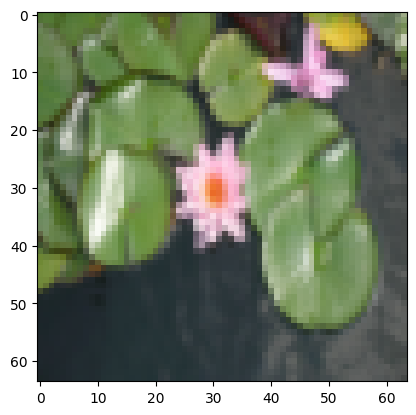

In [52]:
# Example of a picture
index = 26
plt.imshow(train_set_x_orig[index])
print ("y = " + str(train_set_y[:, index]) + ", it's a '" + classes[np.squeeze(train_set_y[:, index])].decode("utf-8") +  "' picture.")

In [53]:
m_train = train_set_x_orig.shape[0]
m_test = test_set_x_orig.shape[0]
num_px = train_set_x_orig.shape[1]

print ("Number of training examples: m_train = " + str(m_train))
print ("Number of testing examples: m_test = " + str(m_test))
print ("Height/Width of each image: num_px = " + str(num_px))
print ("Each image is of size: (" + str(num_px) + ", " + str(num_px) + ", 3)")
print ("train_set_x shape: " + str(train_set_x_orig.shape))
print ("train_set_y shape: " + str(train_set_y.shape))
print ("test_set_x shape: " + str(test_set_x_orig.shape))
print ("test_set_y shape: " + str(test_set_y.shape))

Number of training examples: m_train = 209
Number of testing examples: m_test = 50
Height/Width of each image: num_px = 64
Each image is of size: (64, 64, 3)
train_set_x shape: (209, 64, 64, 3)
train_set_y shape: (1, 209)
test_set_x shape: (50, 64, 64, 3)
test_set_y shape: (1, 50)


**Resize and Flatten the Data** (to resize and reshape x and y of both train and test(num_px, numpx,3)=(64,64,3)

In [54]:
train_set_x_flatten = train_set_x_orig.reshape(train_set_x_orig.shape[0], -1).T
test_set_x_flatten = test_set_x_orig.reshape(test_set_x_orig.shape[0], -1).T

In [55]:
print ("train_set_x_flatten shape: " + str(train_set_x_flatten.shape))
print ("train_set_y shape: " + str(train_set_y.shape))
print ("test_set_x_flatten shape: " + str(test_set_x_flatten.shape))
print ("test_set_y shape: " + str(test_set_y.shape))

train_set_x_flatten shape: (12288, 209)
train_set_y shape: (1, 209)
test_set_x_flatten shape: (12288, 50)
test_set_y shape: (1, 50)


**Standardizing the data**

In [56]:
train_set_x = train_set_x_flatten/255.
test_set_x = test_set_x_flatten/255.

In [57]:
test_set_x.shape

(12288, 50)

In [58]:
train_set_x.shape

(12288, 209)

**Algorithm Explained**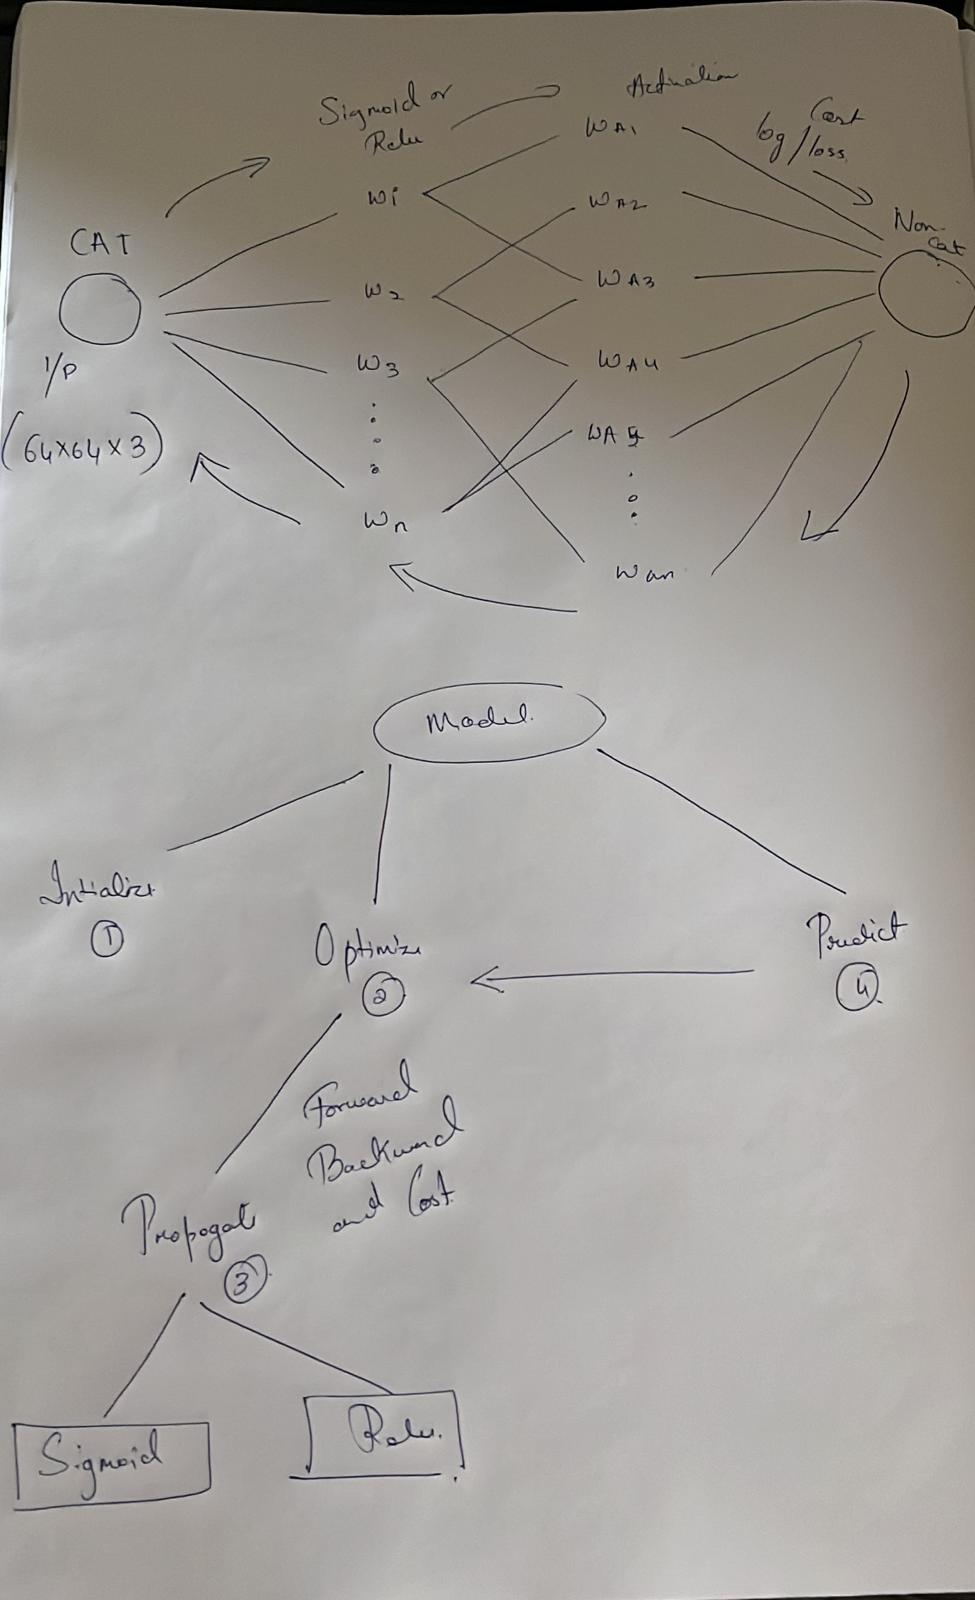

Here is the flow of our algorithm the upward section going to right arrow is forward propogation and below one is backward propogation

**ReLu** is a non-linear activation function that is used in multi-layer neural networks or deep neural networks.
**SIGMOID** A Sigmoid function is a mathematical function which has a characteristic S-shaped curve. There are a number of common sigmoid functions.

**Activation Function**

In [59]:
def sigmoid(z):
    """
    Arguments:
    z -- A scalar or numpy array of any size.
    """
    s = 1 / (1 + np.exp(-z))
    return s

def ReLU(z):
    return np.maximum(z, 0)


## used relu derivative for backward proporgation
def ReLU_deriv(z):
    return z > 0


**Intializing Parameters**

In [60]:
def initialize_with_zeros(dim):
    """
    This function creates a vector of zeros of shape (dim, 1) for w and initializes b to 0.
    
    Argument:
    dim -- size of the w vector we want (or number of parameters in this case)
    
    Returns:
    w -- initialized vector of shape (dim, 1)
    b -- initialized scalar (corresponds to the bias)
    """
    
    w = np.zeros((dim, 1))
    b = 0

    assert(w.shape == (dim, 1))
    assert(isinstance(b, float) or isinstance(b, int))
    
    return w, b
dim = 2
w, b = initialize_with_zeros(dim)
print ("w = " + str(w))
print ("b = " + str(b))

w = [[0.]
 [0.]]
b = 0


In [61]:
def propagate(w, b, X, Y,activation='sigmoid'):
    """
    Arguments:
    w -- weights, a numpy array of size (num_px * num_px * 3, 1)
    b -- bias, a scalar
    X -- data of size (num_px * num_px * 3, number of examples)
    Y -- true "label" vector (containing 0 if non-cat, 1 if cat) of size (1, number of examples)

    Return:
    cost -- negative log-likelihood cost for logistic regression
    dw -- gradient of the loss with respect to w, thus same shape as w
    db -- gradient of the loss with respect to b, thus same shape as b
    """
    
    m = X.shape[1]
    
    # FORWARD PROPAGATION (FROM X TO COST)

   
    if(activation=='sigmoid'):
      A = sigmoid(np.dot(w.T, X)+b)                           # compute activation, size (1, number of examples)
      cost = -(1/m)*(np.dot(Y, np.log(A).T)+np.dot(1-Y, np.log(1-A).T)) # compute cost
      
      dw = (1/m)*np.dot(X, (A-Y).T)
      db = (1/m)*np.sum(A-Y)

    elif(activation=='relu'):
       Z1 = w.T.dot(X) + b
       A = ReLU(Z1)
       cost=mean_squared_error(Y, 1-Y)

       # backward prop 
       dw = (1/m)*np.dot(X, (A-Y).T)
       db = (1/m)*np.sum(A-Y)
       Z2=dw.T.dot(X)+b
       A=ReLU_deriv(Z2)
       
    assert(dw.shape == w.shape)
    assert(db.dtype == float)
    cost = np.squeeze(cost)
    assert(cost.shape == ())
    
    grads = {"dw": dw,
             "db": db}
    return grads, cost

In [62]:
w, b, X, Y = np.array([[1],[2]]), 2, np.array([[1,2],[3,4]]), np.array([[1,0]])

b = np.squeeze(np.asarray(b))

print(X.shape)
grads, cost = propagate(w, b, X, Y,'relu')
print ("dw = " + str(grads["dw"]))
print ("db = " + str(grads["db"]))
print ("cost = " + str(cost))

(2, 2)
dw = [[16.]
 [36.]]
db = 10.0
cost = 1.0


**Stochastic Gradient Descent Optimization**

In [63]:
def sgd_optimize(w, b, X, Y, num_iterations, learning_rate, print_cost = False,activation='sigmoid'):
    """
    This function optimizes w and b by running a stochastic gradient descent algorithm
    
    Arguments:
    w -- weights, a numpy array of size (num_px * num_px * 3, 1)
    b -- bias, a scalar
    X -- data of shape (num_px * num_px * 3, number of examples)
    Y -- true "label" vector (containing 0 if non-cat, 1 if cat), of shape (1, number of examples)
    num_iterations -- number of iterations of the optimization loop
    learning_rate -- learning rate of the gradient descent update rule
    print_cost -- True to print the loss every 100 steps
    
    Returns:
    params -- dictionary containing the weights w and bias b
    grads -- dictionary containing the gradients of the weights and bias with respect to the cost function
    costs -- list of all the costs computed during the optimization, this will be used to plot the learning curve.
    """
    
    costs = []
    np.random.shuffle(X)
    np.random.shuffle(Y)

    for i in range(num_iterations):
        
        
        # Cost and gradient calculation
        grads, cost = propagate(w, b, X, Y,activation)
        
        # Retrieve derivatives from grads
        dw = grads["dw"]
        db = grads["db"]
        
        ### START CODE HERE ###
        w = w - learning_rate * dw
        b = b - learning_rate * db
        ### END CODE HERE ###
        
        # Record the costs
        if i % 100 == 0:
            costs.append(cost)
        
        # Print the cost every 1000 training examples
        if print_cost and i % 1000 == 0:
            print ("Cost after iteration %i: %f" %(i, cost))
    
    params = {"w": w,
              "b": b}
    
    grads = {"dw": dw,
             "db": db}
    
    return params, grads, costs

In [64]:
params, grads, costs = sgd_optimize(w, b, X, Y, num_iterations= 100, learning_rate = 0.009, print_cost = True,activation='relu')
print ("w = " + str(params["w"]))
print ("b = " + str(params["b"]))
print ("dw = " + str(grads["dw"]))
print ("db = " + str(grads["db"]))

Cost after iteration 0: 1.000000
w = [[-0.78604826]
 [ 1.04226658]]
b = 1.5858425769202191
dw = [[-0.04272335]
 [ 0.16130221]]
db = -0.10201278109844047


**Predict Function**

In [65]:
def predict(w, b, X,activation='sigmoid'):
    '''
    Predict whether the label is 0 or 1 using learned logistic regression parameters (w, b)
    
    Arguments:
    w -- weights, a numpy array of size (num_px * num_px * 3, 1)
    b -- bias, a scalar
    X -- data of size (num_px * num_px * 3, number of examples)
    
    Returns:
    Y_prediction -- a numpy array (vector) containing all predictions (0/1) for the examples in X
    '''
    
    m = X.shape[1]
    Y_prediction = np.zeros((1,m))
    w = w.reshape(X.shape[0], 1)
    
    # Compute vector "A" predicting the probabilities of a cat being present in the picture
    if activation=='relu':
      Z1 = w.T.dot(X) + b
      A = ReLU(Z1)
    elif activation=='sigmoid':
      A = sigmoid(np.dot(w.T,X) + b)
    
    for i in range(A.shape[1]):
        
        # Convert probabilities A[0,i] to actual predictions p[0,i]
        if (A[0,i] <=0.5):
            Y_prediction[0,i] = 0
        elif (A[0,i] > 0.5):
            Y_prediction[0,i] = 1
        pass
    
    assert(Y_prediction.shape == (1, m))
    
    return Y_prediction

In [66]:
print(w)

[[1]
 [2]]


In [67]:
print ("predictions = " + str(predict(w, b, X,'relu')))

predictions = [[1. 1.]]


**Assemble Model**

In [68]:
# GRADED FUNCTION: model

def model(X_train, Y_train, X_test, Y_test, num_iterations = 4000, learning_rate = 0.50, print_cost = False,activation='sigmoid'):
    """    
    Arguments:
    X_train -- training set represented by a numpy array of shape (num_px * num_px * 3, m_train)
    Y_train -- training labels represented by a numpy array (vector) of shape (1, m_train)
    X_test -- test set represented by a numpy array of shape (num_px * num_px * 3, m_test)
    Y_test -- test labels represented by a numpy array (vector) of shape (1, m_test)
    num_iterations -- hyperparameter representing the number of iterations to optimize the parameters
    learning_rate -- hyperparameter representing the learning rate used in the update rule of optimize()
    print_cost -- Set to true to print the cost every 100 iterations
    
    Returns:
    d -- dictionary containing information about the model.
    """    
    # initialize parameters with zeros 
    w, b = initialize_with_zeros(X_train.shape[0])

    # Gradient descent 
    parameters, grads, costs = sgd_optimize(w, b, X_train, Y_train, num_iterations, learning_rate, print_cost,activation)
    
    # Retrieve parameters w and b from dictionary "parameters"
    w = parameters["w"]
    b = parameters["b"]
    
    # Predict test/train set examples
    Y_prediction_test = predict(w, b, X_test)
    Y_prediction_train = predict(w, b, X_train)


    # Printing train/test Errors
    print("train accuracy: {} %".format(100 - np.mean(np.abs(Y_prediction_train - Y_train)) * 100))
    print("test accuracy: {} %".format(100 - np.mean(np.abs(Y_prediction_test - Y_test)) * 100))

    
    d = {"costs": costs,
         "Y_prediction_test": Y_prediction_test, 
         "Y_prediction_train" : Y_prediction_train, 
         "w" : w, 
         "b" : b,
         "learning_rate" : learning_rate,
         "num_iterations": num_iterations}
    
    return d

In [69]:
d = model(train_set_x, train_set_y, test_set_x, test_set_y, num_iterations = 11000, learning_rate = 0.001, print_cost = True,activation='relu')

Cost after iteration 0: 1.000000
Cost after iteration 1000: 1.000000
Cost after iteration 2000: 1.000000
Cost after iteration 3000: 1.000000
Cost after iteration 4000: 1.000000
Cost after iteration 5000: 1.000000
Cost after iteration 6000: 1.000000
Cost after iteration 7000: 1.000000
Cost after iteration 8000: 1.000000
Cost after iteration 9000: 1.000000
Cost after iteration 10000: 1.000000
train accuracy: 74.16267942583733 %
test accuracy: 64.0 %


**Random images to predict**

Index No: 36 y = 0, you predicted that it is a "cat" picture.


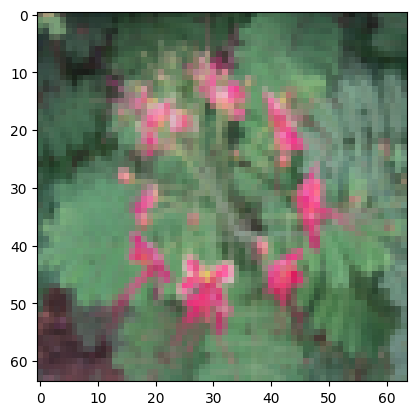

In [70]:
index = random.randint(0,49)
plt.imshow(test_set_x[:,index].reshape((num_px, num_px, 3)))
val=d["Y_prediction_test"][0,index]
val=int(val)
val=classes[val]
val=val.decode("utf-8")
print ("Index No: " + str(index) +  " y = " + str(test_set_y[0,index]) + ", you predicted that it is a \"" + val +  "\" picture.")

Index No: 35 y = 0, you predicted that it is a "cat" picture.


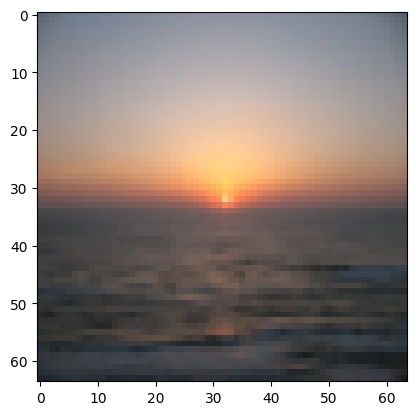

In [71]:
index = random.randint(0,49)
plt.imshow(test_set_x[:,index].reshape((num_px, num_px, 3)))
val=d["Y_prediction_test"][0,index]
val=int(val)
val=classes[val]
val=val.decode("utf-8")
print ("Index No: " + str(index) +  " y = " + str(test_set_y[0,index]) + ", you predicted that it is a \"" + val +  "\" picture.")

Index No: 46 y = 1, you predicted that it is a "cat" picture.


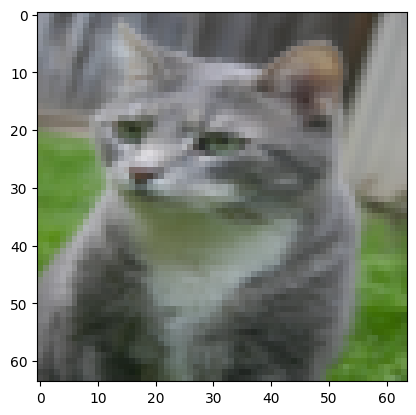

In [72]:
index = random.randint(0,49)
plt.imshow(test_set_x[:,index].reshape((num_px, num_px, 3)))
val=d["Y_prediction_test"][0,index]
val=int(val)
val=classes[val]
val=val.decode("utf-8")
print ("Index No: " + str(index) +  " y = " + str(test_set_y[0,index]) + ", you predicted that it is a \"" + val +  "\" picture.")

Index No: 13 y = 0, you predicted that it is a "cat" picture.


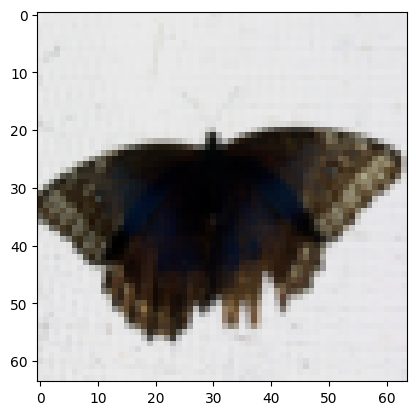

In [73]:
index = random.randint(0,49)
plt.imshow(test_set_x[:,index].reshape((num_px, num_px, 3)))
val=d["Y_prediction_test"][0,index]
val=int(val)
val=classes[val]
val=val.decode("utf-8")
print ("Index No: " + str(index) +  " y = " + str(test_set_y[0,index]) + ", you predicted that it is a \"" + val +  "\" picture.")

Index No: 15 y = 1, you predicted that it is a "cat" picture.


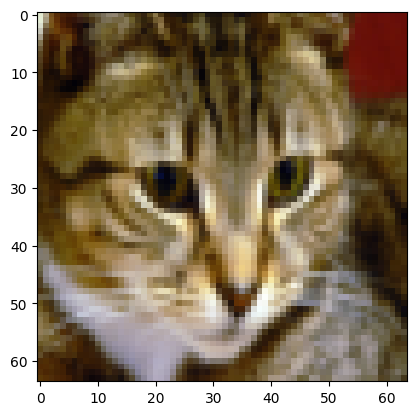

In [74]:
index = random.randint(0,50)
plt.imshow(test_set_x[:,index].reshape((num_px, num_px, 3)))
val=d["Y_prediction_test"][0,index]
val=int(val)
val=classes[val]
val=val.decode("utf-8")
print ("Index No: " + str(index) +  " y = " + str(test_set_y[0,index]) + ", you predicted that it is a \"" + val +  "\" picture.")

##F1 Score Interpretation

0.9 Very good
0.8 - 0.9 Good
0.5 - 0.8 OK.
< 0.5 Not good.

We got 0.79 Thats GOOD SCORE

importing f1 score

In [75]:
from sklearn.metrics import f1_score

In [76]:
f1_score(test_set_y,d["Y_prediction_test"], average='micro')

0.7804878048780488

**Mean Square Error**


Checking Accuracy

In [77]:
print('Mean Squared Error :',mean_squared_error(test_set_y, d["Y_prediction_test"]))

Mean Squared Error : 0.36


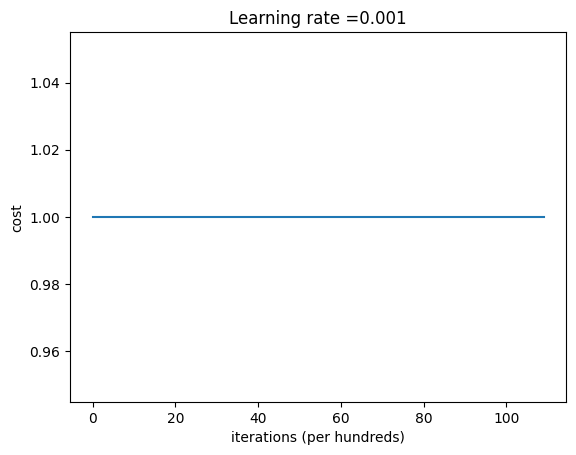

In [78]:
# Plot learning curve (with costs)
costs = np.squeeze(d['costs'])
plt.plot(costs)
plt.ylabel('cost')
plt.xlabel('iterations (per hundreds)')
plt.title("Learning rate =" + str(d["learning_rate"]))
plt.show()

**To Check the best learning rate model**

**RELU**

learning rate is: 0.01
train accuracy: 65.55023923444976 %
test accuracy: 34.0 %

-------------------------------------------------------

learning rate is: 0.001
train accuracy: 74.16267942583733 %
test accuracy: 66.0 %

-------------------------------------------------------

learning rate is: 0.0001
train accuracy: 50.717703349282296 %
test accuracy: 66.0 %

-------------------------------------------------------



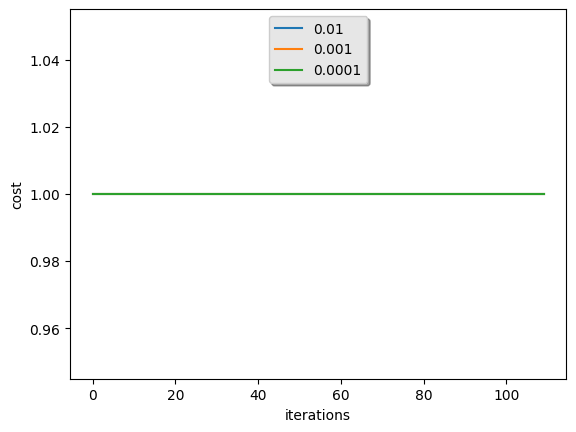

In [79]:
learning_rates = [0.01,0.001, 0.0001]
#learning_rates = [0.001]

models = {}
for i in learning_rates:
    print ("learning rate is: " + str(i))
    models[str(i)] = model(train_set_x, train_set_y, test_set_x, test_set_y, num_iterations = 11000, learning_rate = i, print_cost = False,activation="relu")
    print ('\n' + "-------------------------------------------------------" + '\n')

for i in learning_rates:
    plt.plot(np.squeeze(models[str(i)]["costs"]), label= str(models[str(i)]["learning_rate"]))

plt.ylabel('cost')
plt.xlabel('iterations')

legend = plt.legend(loc='upper center', shadow=True)
frame = legend.get_frame()
frame.set_facecolor('0.90')
plt.show()

**Sigmoid**

learning rate is: 0.01
train accuracy: 100.0 %
test accuracy: 58.0 %

-------------------------------------------------------

learning rate is: 0.001
train accuracy: 99.04306220095694 %
test accuracy: 58.0 %

-------------------------------------------------------

learning rate is: 0.0001
train accuracy: 86.60287081339713 %
test accuracy: 34.0 %

-------------------------------------------------------



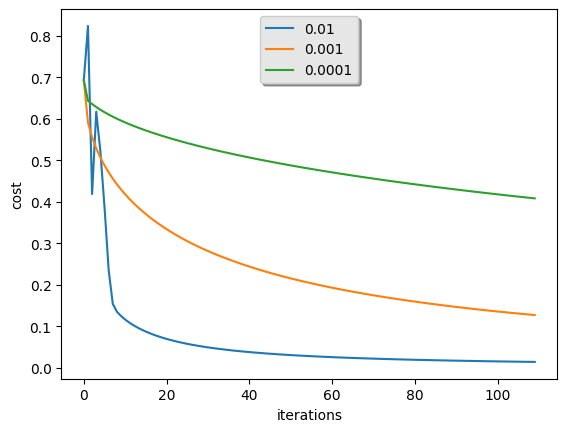

In [80]:
learning_rates = [0.01,0.001, 0.0001]
#learning_rates = [0.001]

models = {}
for i in learning_rates:
    print ("learning rate is: " + str(i))
    models[str(i)] = model(train_set_x, train_set_y, test_set_x, test_set_y, num_iterations = 11000, learning_rate = i, print_cost = False,activation="sigmoid")
    print ('\n' + "-------------------------------------------------------" + '\n')

for i in learning_rates:
    plt.plot(np.squeeze(models[str(i)]["costs"]), label= str(models[str(i)]["learning_rate"]))

plt.ylabel('cost')
plt.xlabel('iterations')

legend = plt.legend(loc='upper center', shadow=True)
frame = legend.get_frame()
frame.set_facecolor('0.90')
plt.show()

**To Predict Image outside the dataset**

<ipython-input-81-d478239cc56d>:11: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = np.array(imageio.imread(fname))


y = 1.0, your algorithm predicts a "cat" picture.


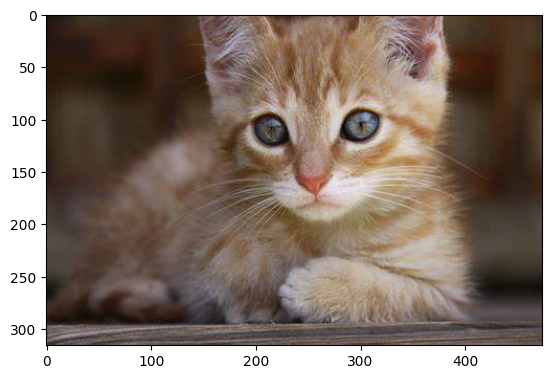

In [81]:
import imageio
from skimage.transform import resize

## START CODE HERE ## (PUT YOUR IMAGE NAME) 
my_image = "/content/drive/MyDrive/ADS-2/cat.jpeg"   # change this to the name of your image file 
## END CODE HERE ##

# We preprocess the image to fit your algorithm.

fname = my_image
image = np.array(imageio.imread(fname))
my_image = resize(image, (num_px,num_px)).reshape((1, num_px*num_px*3)).T
my_predicted_image = predict(d["w"], d["b"], my_image)

plt.imshow(image)
print("y = " + str(np.squeeze(my_predicted_image)) + ", your algorithm predicts a \"" + classes[int(np.squeeze(my_predicted_image)),].decode("utf-8") +  "\" picture.")
